In [0]:
from sklearn.preprocessing import MinMaxScaler
import os, sys
import numpy as np
import pandas as pd
import time
import random
from ta import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import requests, json, re
from datetime import date
import copy
import pickle


In [0]:
!pip install h2ogpu

In [0]:
def softmax(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis]
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis]
    return e_x / div
  
def get_state(parameters, t, window_size = 20):
    outside = []
    d = t - window_size + 1
    for parameter in parameters:
        block = (
            parameter[d : t + 1]
            if d >= 0
            else -d * [parameter[0]] + parameter[0 : t + 1]
        )
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        for i in range(1, window_size, 1):
            res.append(block[i] - block[0])
        outside.append(res)
    return np.array(outside).reshape((1, -1))  
  
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
#     # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

#     # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(3).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    #Add momentum
    dataset['momentum'] = dataset['Close']-1
    dataset['Date'] = dataset['Date']
  
    return dataset

def add_fourier_feature(df):
    close_fft = np.fft.fft(np.asarray(df['Close'].tolist()))
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9, 100]:
        fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
        df["fourier_comp_{}".format(num_)] = np.fft.ifft(fft_list_m10).real
        
    return df
    
def convert_amount(amount):
    try:
        amount = float(amount)
    except ValueError:
        pass
    return amount
  
  
  
def get_comission_fee(n_stocks, price):
	fee_per_share = 0.005
	min_order_fee = 1
	max_order_fee = 0.01 #%
 
	if fee_per_share * n_stocks <= min_order_fee:
		return min_order_fee

	elif fee_per_share * n_stocks >= (price * n_stocks) * max_order_fee:
		return (price * n_stocks) * max_order_fee

	else:
		return n_stocks * fee_per_share 




In [0]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights
    
    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')
        
class Model:
    
    DROPOUT = 0.9
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.normal(scale = 0.05, size = (input_size, layer_size)),
            np.random.normal(scale = 0.05, size = (layer_size, layer_size)),
            np.random.normal(scale = 0.05, size = (layer_size, output_size)),
            np.zeros((1, layer_size)),
            np.zeros((1, layer_size)),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-2]
        feed = np.dot(feed, self.weights[1]) + self.weights[-1]
        decision = np.dot(feed, self.weights[2])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [0]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, timeseries, skip, initial_money, real_trend):
        self.model = model
        self.timeseries = timeseries
        self.skip = skip
        self.real_trend = real_trend
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )
        self._initiate()
        
        
    def _initiate(self):
        # i assume first index is the close value
        self.trend = self.timeseries[0]
        self._mean = np.mean(self.trend)
        self._std = np.std(self.trend)
        self._inventory = []
        self._capital = self.initial_money
        self._queue = []
        self._min = np.min(self.real_trend)
        self._max = np.max(self.real_trend)
        self._scaled_capital = self._scale(self._capital)
    
    def reset_capital(self, capital):
        if capital:
            self._capital = capital
        self._scaled_capital = self._scale(self._capital)
        self._queue = []
        self._inventory = []
        
    def _scale(self, data):
        std = (data - self._min) / (self._max - self._min)
        return std * 100 + 100
    
    def _reverse_scale(self, data):
        std = (data - 100) / 100
        return (std * (self._max - self._min)) + self._min
        
    def trade(self, data):
        """
        you need to make sure the data is [close, volume]
        """
        scaled_data = [self._scale(d) for d in data]
        real_close = data[0]
        close = scaled_data[0]
        if len(self._queue) > window_size:
            self._queue.pop(0)
        self._queue.append(scaled_data)
        if len(self._queue) < window_size:
            return {'status': 'data not enough to trade', 'action': 'fail',
                    'balance': self._capital,
                    'timestamp': str(datetime.now())}
        state = self.get_state(window_size - 1, 
                       self._inventory,
                       self._scaled_capital,
                       timeseries = np.array(self._queue).T.tolist())
        action = self.act(state)
        if action == 1 and self._scaled_capital >= close:
            self._inventory.append(close)
            self._scaled_capital -= close
            self._capital -= real_close
            return {'status': 'buy 1 unit, cost %f'%(real_close),
                    'action': 'buy',
                    'balance': self._capital,
                    'timestamp': str(datetime.now())}
        elif action == 2 and len(self._inventory):
            bought_price = self._inventory.pop(0)
            self._scaled_capital += close
            self._capital += real_close
            scaled_bought_price = self._reverse_scale(bought_price)
            try:
                invest = ((real_close - scaled_bought_price) / scaled_bought_price) * 100
            except:
                invest = 0
            return {'status': 'sell 1 unit, price %f'%(real_close),
                    'investment': '%f %%'%(invest),
                    'balance': self._capital,
                    'action': 'sell', 
                    'timestamp': str(datetime.now())}
        else:
            return {'status': 'do nothing', 'action': 'nothing',
                    'balance': self._capital,
                    'timestamp': str(datetime.now())}
        
            
    
    def change_data(self, timeseries, skip, initial_money, real_trend):
        self.timeseries = timeseries
        self.skip = skip
        self.initial_money = initial_money
        self.real_trend = real_trend
        self._initiate()
    
    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t, inventory, capital, timeseries):
        state = get_state(timeseries, t)
        len_inventory = len(inventory)
        if len_inventory:
            mean_inventory = np.mean(inventory)
        else:
            mean_inventory = 0
        z_inventory = (mean_inventory - self._mean) / self._std
        z_capital = (capital - self._mean) / self._std
        concat_parameters = np.concatenate([state, [[len_inventory,
                                                     z_inventory,
                                                     z_capital]]], axis = 1)
        return concat_parameters
        
    
    def get_reward(self, weights):
        initial_money = self._scaled_capital
        starting_money = initial_money
        self.model.weights = weights
        inventory = []
        state = self.get_state(0, inventory, starting_money, self.timeseries)
        
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= self.trend[t] - get_comission_fee(1, self.trend[t])
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t] - get_comission_fee(1, self.trend[t])

            state = self.get_state(t + 1, inventory, starting_money, self.timeseries)
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)
        
    def buy(self):
        initial_money = self._scaled_capital
        starting_money = initial_money
        
        real_initial_money = self.initial_money
        real_starting_money = self.initial_money
        inventory = []
        real_inventory = []
        state = self.get_state(0, inventory, starting_money, self.timeseries)
        states_sell = []
        states_buy = []
        
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                real_inventory.append(self.real_trend[t])
                real_starting_money -= self.real_trend[t]  + get_comission_fee(1, self.real_trend[t])
                starting_money -= self.trend[t]  + get_comission_fee(1, self.real_trend[t])
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f with comission %f, total balance %f'% (t, self.real_trend[t], 
                                                                           get_comission_fee(1, self.real_trend[t]), real_starting_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                real_bought_price = real_inventory.pop(0)
                starting_money += self.trend[t] - get_comission_fee(1, self.real_trend[t])
                real_starting_money += self.real_trend[t] - get_comission_fee(1, self.real_trend[t])
                states_sell.append(t)
                try:
                    invest = ((self.real_trend[t] - real_bought_price) / real_bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f with comission %f, investment %f %%, total balance %f,'
                    % (t, self.real_trend[t], get_comission_fee(1, self.real_trend[t]), invest, real_starting_money)
                )
            state = self.get_state(t + 1, inventory, starting_money, self.timeseries)
        
        invest = ((real_starting_money - real_initial_money) / real_initial_money) * 100
        total_gains = real_starting_money - real_initial_money
        return states_buy, states_sell, total_gains, invest

In [0]:
skip = 1
layer_size = 500
output_size = 3
window_size = 30
trading_years = 2

/usr/local/lib/python3.6/dist-packages/ta/trend.py:170: RuntimeWarning: divide by zero encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:174: RuntimeWarning: divide by zero encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:176: RuntimeWarning: invalid value encountered in subtract
  dx = 100 * np.abs((dip - din) / (dip + din))


iter 1. reward: -77.033064
iter 2. reward: 50.553933
iter 3. reward: 81.177626
iter 4. reward: 52.696598
iter 5. reward: 66.175789
iter 6. reward: 39.526793
iter 7. reward: 105.888212
iter 8. reward: 77.099370
iter 9. reward: 78.444839
iter 10. reward: 103.768003
iter 11. reward: 105.760605
iter 12. reward: 77.322503
iter 13. reward: 71.325806
iter 14. reward: 74.277918
iter 15. reward: 69.666938
iter 16. reward: 110.866641
iter 17. reward: 111.347037
iter 18. reward: 103.014421
iter 19. reward: 67.200996
iter 20. reward: 77.782424
iter 21. reward: 66.696937
iter 22. reward: 89.646348
iter 23. reward: 103.481208
iter 24. reward: 86.039670
iter 25. reward: 89.660598
iter 26. reward: 102.122361
iter 27. reward: 104.008719
iter 28. reward: 112.340488
iter 29. reward: 119.339266
iter 30. reward: 123.908542
iter 31. reward: 131.468894
iter 32. reward: 115.932643
iter 33. reward: 117.988831
iter 34. reward: 125.527065
iter 35. reward: 130.896454
iter 36. reward: 127.862786
iter 37. reward: 1

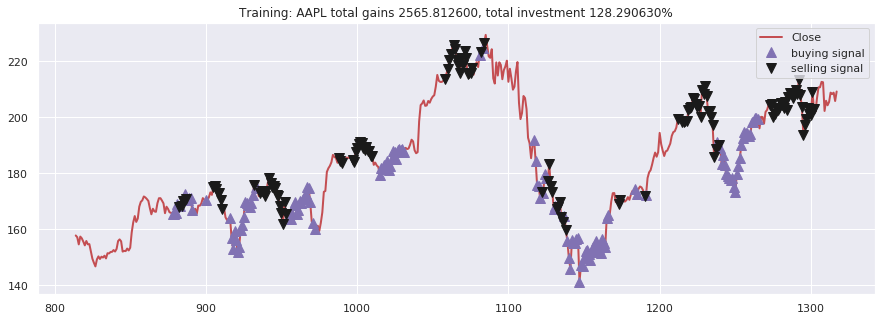

In [95]:
tickers = ["AAPL"]
for ticker in tickers:
    response = requests.get("https://financialmodelingprep.com/api/v3/historical-price-full/" + ticker)
    if response.status_code == 200:
        data = json.loads(response.content.decode('utf-8'))
        
    lst = data["historical"]
    df = pd.DataFrame(lst)
    df = df[-252*trading_years:]
    
    
    df = df.rename(columns={
        "date": "Date",
        "open": "Open", 
        "high": "High", 
        "low": "Low", 
        "close": "Close", 
        "volume": "Volume"            
    })
    
    df = df.drop(columns=[
        "unadjustedVolume",
        "change",
        "changePercent",
        "vwap",
        "label",
        "changeOverTime"
    ])
    
    df = add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=True)
    df = get_technical_indicators(df)
    df = add_fourier_feature(df)
    df = df.drop(columns=["fourier_comp_100", "High", "Low", "Open"])
    today = date.today()
    df.to_csv("{}_{}.csv".format(ticker, today.strftime("%d-%m-%y")))
    

    input_size = 725 #for 14 inputs

    model = Model(input_size = input_size, layer_size = layer_size, output_size = output_size)
    agent = None


    parameters = [
    #     df['momentum'].tolist(),     
        df['Close'].tolist(),
        df['ema'].tolist(), 
        df['ma7'].tolist(), 
        df['trend_ema_fast'].tolist(), 
        df['volatility_kcc'].tolist(), 
        df['volatility_kcl'].tolist(), 
        df['volatility_kch'].tolist(),
        df['trend_ichimoku_a'].tolist(),
        df['trend_ema_slow'].tolist(),
        df['26ema'].tolist(),
        df['volatility_bbm'].tolist(),
        df['ma21'].tolist(),
        df['volatility_dch'].tolist(),
        df['volatility_dcl'].tolist(),
        df['lower_band'].tolist(),
        df['fourier_comp_9'].tolist(),
        df['fourier_comp_6'].tolist(),
        df['fourier_comp_3'].tolist(),
        df['upper_band'].tolist()
    
    ]

    real_trend = df['Close'].tolist()
    stock_mean = df['Close'].mean()
    stock_std = df['Close'].std()
    scaled_parameters = MinMaxScaler(feature_range = (100, 200)).fit_transform(np.array(parameters).T).T.tolist()
    initial_money = 2000

    agent = Agent(model = model,
                          timeseries = scaled_parameters,
                          skip = skip,
                          initial_money = initial_money,
                          real_trend = real_trend)


    agent.fit(iterations = 100, checkpoint = 1)
    
    copy_model = copy.deepcopy(agent.model)

    with open('model_{}_{}.pkl'.format(ticker, today.strftime("%d-%m-%y")), 'wb') as fopen:
      pickle.dump(copy_model, fopen)
      
    states_buy, states_sell, total_gains, invest = agent.buy()
    fig = plt.figure(figsize = (15, 5))
    plt.plot(df['Close'], color='r', lw=2.)
    plt.plot(df['Close'], '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
    plt.plot(df['Close'], 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
    plt.title('Training: %s total gains %f, total investment %f%%'%(ticker, total_gains, invest))
    plt.legend()
    plt.show()
    
    
   
    